In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

plt.style.use('seaborn-v0_8-darkgrid')

tickrs = ['RELIANCE.NS', 'TCS.NS','INFY.NS']
data = yf.download(tickrs, start = '2023-01-01', end= '2025-01-01')

close = data['Close']
log_returns = np.log(close/close.shift(1)).dropna()

print("Data Loaded Successfully")
print(f"Shape: {log_returns.shape}")

In [ ]:
daily_volatality = log_returns.std()
annual_volatality = daily_volatality*np.sqrt(252)
print("\nDaily Volatality")
print(daily_volatality)
print("\nAnnulaized Volatility")
print(annual_volatality)

##What is Volatility?##

Volatility = Standard Deviation of Returns

It measures how much a stock's price fluctuates.

It measures how much a stock's price fluctuates.
- High Volatility = big price wings = riskier stock
- Low Volatility = stable price = safer stock

We annualize by multiplying by sqrt(252) because:
- There are 252 trading days in a year
- Returns scale linearly with time
- Volatility scales with square root of time(this is from Brownian Motion theory)

This is one of the core inputs to Black-Scholes options pricing!

In [ ]:
# 30-day rolling volatility
rolling_vol = log_returns.rolling(window = 30).std() * np.sqrt(252)

plt.figure(figsize = (14,6))
for tickr in tickrs:
    plt.plot(rolling_vol[tickr],label = tickr)

plt.title("30-day Rolling Annualized Volatility (2023-2025)")
plt.xlabel("Date")
plt.ylabel("Price(INR)")
plt.legend()
plt.tight_layout()
plt.savefig('rolling_volatility.png')
plt.show()

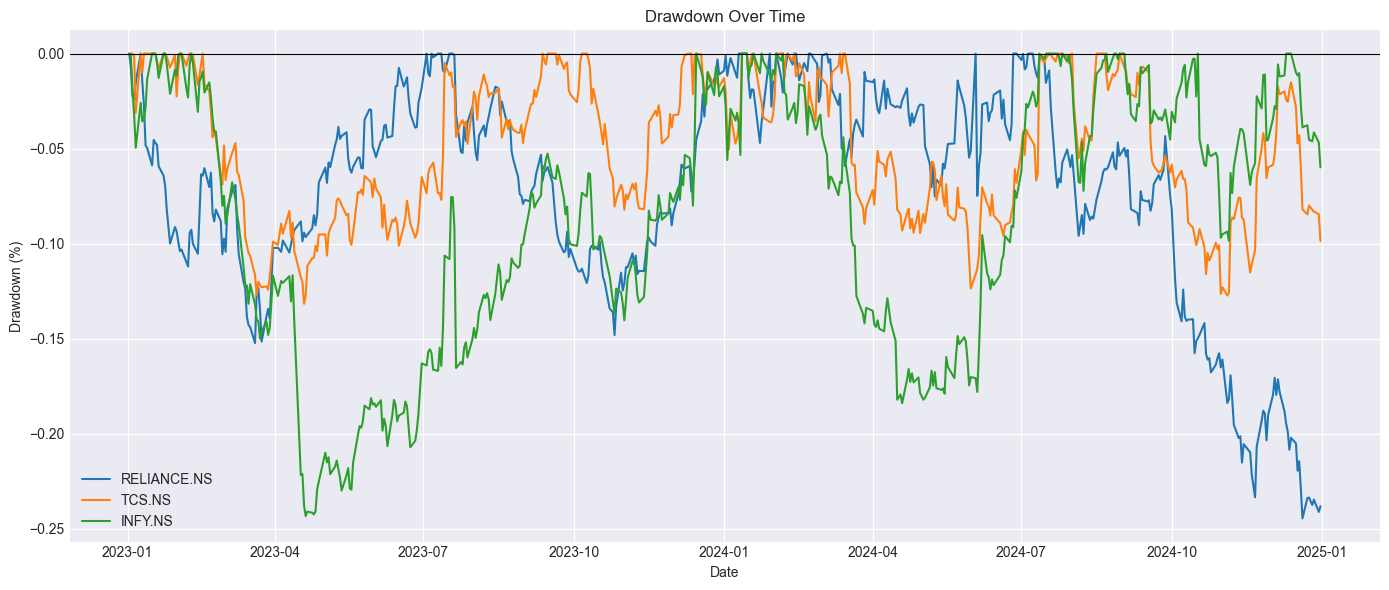

In [12]:
def compute_drawdown(price_series):
    """
    Drawdown = how far we are from the rolling peak (in %)
    Maximum Drawdown = worst single peak-to-trough fall
    """
    # Rolling peak (highest price seen so far)
    rolling_peak = price_series.cummax()
    
    # Drawdown at each point
    drawdown = (price_series - rolling_peak) / rolling_peak
    
    return drawdown

# Compute for each stock
plt.figure(figsize=(14, 6))
for ticker in tickrs:
    dd = compute_drawdown(close[ticker].dropna())
    plt.plot(dd, label=ticker)

plt.title("Drawdown Over Time")
plt.xlabel("Date")
plt.ylabel("Drawdown (%)")
plt.axhline(0, color='black', linewidth=0.8)
plt.legend()
plt.tight_layout()
plt.savefig("drawdown.png")
plt.show()

In [13]:
print("=" * 50)
print("Maximum Drawdown (MDD)")
print("=" * 50)

for ticker in tickrs:
    dd = compute_drawdown(close[ticker].dropna())
    mdd = dd.min()  # most negative value = worst drawdown
    print(f"{ticker}: MDD = {mdd:.2%}")

print()
print("MDD tells you: if you invested at the worst possible time (the peak),")
print("how much would you have lost at the absolute worst point?")
print("This is KEY in Dr. Jindal's FOUI-LR paper — they optimize portfolios")
print("to MINIMIZE this kind of downside risk.")

Maximum Drawdown (MDD)
RELIANCE.NS: MDD = -24.46%
TCS.NS: MDD = -13.17%
INFY.NS: MDD = -24.34%

MDD tells you: if you invested at the worst possible time (the peak),
how much would you have lost at the absolute worst point?
This is KEY in Dr. Jindal's FOUI-LR paper — they optimize portfolios
to MINIMIZE this kind of downside risk.


In [15]:
confidence_level = 0.95  # 95% confidence

print("=" * 50)
print(f"Value at Risk (VaR) at {confidence_level*100:.0f}% Confidence")
print("=" * 50)

for ticker in tickrs:
    # Historical VaR: just take the 5th percentile of returns
    VaR = np.percentile(log_returns[ticker].dropna(), (1 - confidence_level) * 100)
    print(f"{ticker}: VaR = {VaR:.2%}")
    print(f"  → On a bad day (1 in 20), you could lose {abs(VaR):.2%} or more")
    print()

Value at Risk (VaR) at 95% Confidence
RELIANCE.NS: VaR = -1.90%
  → On a bad day (1 in 20), you could lose 1.90% or more

TCS.NS: VaR = -1.78%
  → On a bad day (1 in 20), you could lose 1.78% or more

INFY.NS: VaR = -1.95%
  → On a bad day (1 in 20), you could lose 1.95% or more



In [16]:
# Final summary table combining all risk metrics
print("=" * 60)
print("RISK METRICS SUMMARY")
print("=" * 60)

summary = []
for ticker in tickrs:
    ret = log_returns[ticker].dropna()
    price = close[ticker].dropna()
    
    ann_vol = ret.std() * np.sqrt(252)
    mdd = compute_drawdown(price).min()
    var_95 = np.percentile(ret, 5)
    mean_return = ret.mean() * 252  # annualized
    
    summary.append({
        "Ticker": ticker,
        "Ann. Return": f"{mean_return:.2%}",
        "Ann. Volatility": f"{ann_vol:.2%}",
        "Max Drawdown": f"{mdd:.2%}",
        "VaR (95%)": f"{var_95:.2%}"
    })

summary_df = pd.DataFrame(summary).set_index("Ticker")
print(summary_df.to_string())
print()
print("Next up → Day 3: We'll use these metrics to compute Sharpe Ratio")
print("and the Ulcer Index — the star of Dr. Jindal's FOUI-LR paper!")

RISK METRICS SUMMARY
            Ann. Return Ann. Volatility Max Drawdown VaR (95%)
Ticker                                                        
RELIANCE.NS       1.50%          20.33%      -24.46%    -1.90%
TCS.NS           14.48%          19.62%      -13.17%    -1.78%
INFY.NS          13.75%          23.16%      -24.34%    -1.95%

Next up → Day 3: We'll use these metrics to compute Sharpe Ratio
and the Ulcer Index — the star of Dr. Jindal's FOUI-LR paper!
